# **Fresh Check Model**

# Download and Prepare the Dataset




In [ ]:
#install kaggle
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wifalinola","key":"4e9a61959213153b03d226514bc60021"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d raghavrpotdar/fresh-and-stale-images-of-fruits-and-vegetables

 99% 1.40G/1.41G [00:10<00:00, 169MB/s]
100% 1.41G/1.41G [00:10<00:00, 140MB/s]


In [ ]:
! unzip fresh-and-stale-images-of-fruits-and-vegetables.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.09 PM.png  
  inflating: stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.15 PM.png  
  inflating: stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.24 PM.png  
  inflating: stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.32 PM.png  
  inflating: stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.02.38 PM.png  
  inflating: stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.06.21 PM.png  
  inflating: stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.06.27 PM.png  
  inflating: stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.06.33 PM.png  
  inflating: stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.06.40 PM.png  
  inflating: stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.06.56 PM.png  
  inflating: stale_banana/rotated_by_15_Screen Shot 2018-06-12 at 9.07.04 PM.png  
  inflating: stale_banana/ro

In [ ]:
# grader-required-cell

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [ ]:
! mkdir '/content/fresh-and-stale-images-of-fruits-and-vegetables'

In [ ]:
!mv '/content/fresh_apple' "/content/fresh-and-stale-images-of-fruits-and-vegetables/fresh_apple"
!mv '/content/fresh_banana' "/content/fresh-and-stale-images-of-fruits-and-vegetables/fresh_banana"
!mv '/content/fresh_orange' "/content/fresh-and-stale-images-of-fruits-and-vegetables/fresh_orange"
!mv '/content/fresh_tomato' "/content/fresh-and-stale-images-of-fruits-and-vegetables/fresh_tomato"
!mv '/content/fresh_bitter_gourd' "/content/fresh-and-stale-images-of-fruits-and-vegetables/fresh_bitter_gourd"
!mv '/content/fresh_capsicum' "/content/fresh-and-stale-images-of-fruits-and-vegetables/fresh_capsicum"

!mv '/content/stale_apple' "/content/fresh-and-stale-images-of-fruits-and-vegetables/stale_apple"
!mv '/content/stale_banana' "/content/fresh-and-stale-images-of-fruits-and-vegetables/stale_banana"
!mv '/content/stale_orange' "/content/fresh-and-stale-images-of-fruits-and-vegetables/stale_orange"
!mv '/content/stale_tomato' "/content/fresh-and-stale-images-of-fruits-and-vegetables/stale_tomato"
!mv '/content/stale_bitter_gourd' "/content/fresh-and-stale-images-of-fruits-and-vegetables/stale_bitter_gourd"
!mv '/content/stale_capsicum' "/content/fresh-and-stale-images-of-fruits-and-vegetables/stale_capsicum"


# Prepare the ImageDataGenerator

In [ ]:
trainings_datagen = ImageDataGenerator(
    rescale = 1./255,
    fill_mode='nearest',
    validation_split=0.2 # Trainingnya 80% Validasinya 20% (validasi = test),
)

val_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

In [ ]:
BASE_DIR = '/content/fresh-and-stale-images-of-fruits-and-vegetables/'

In [ ]:
train_generator = trainings_datagen.flow_from_directory(
    BASE_DIR,
    class_mode='categorical',
    seed=42,
    target_size=(224, 224), 
    shuffle=True,
    subset='training')
validation_generator = val_datagen.flow_from_directory(
    BASE_DIR,
    seed=42,
    class_mode='categorical',
    target_size=(224, 224),
    subset='validation')

Found 11749 images belonging to 12 classes.
Found 2933 images belonging to 12 classes.


# Build the Model

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                                 
 dropout (Dropout)           (None, 93312)             0

In [ ]:
def adjust_learning_rate(dataset):
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    ### START CODE HERE
    
    # Select your optimizer
    optimizer = tf.keras.optimizers.RMSprop()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=optimizer, 
                  metrics=["accuracy"]) 
    
    ### END CODE HERE
    
    history = model.fit(dataset, epochs=20, callbacks=[lr_schedule])
    
    return history

In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_generator)

Epoch 1/20
368/368 [==============================] - 58s 153ms/step - loss: 0.0012 - accuracy: 0.9995 - lr: 1.0000e-04
Epoch 2/20
368/368 [==============================] - 53s 144ms/step - loss: 0.0014 - accuracy: 0.9997 - lr: 1.1220e-04
Epoch 3/20
368/368 [==============================] - 54s 147ms/step - loss: 2.8774e-04 - accuracy: 1.0000 - lr: 1.2589e-04
Epoch 4/20
368/368 [==============================] - 54s 148ms/step - loss: 6.4625e-04 - accuracy: 0.9998 - lr: 1.4125e-04
Epoch 5/20
368/368 [==============================] - 53s 144ms/step - loss: 3.1232e-04 - accuracy: 0.9999 - lr: 1.5849e-04
Epoch 6/20
368/368 [==============================] - 53s 145ms/step - loss: 3.6717e-04 - accuracy: 0.9998 - lr: 1.7783e-04
Epoch 7/20
368/368 [==============================] - 53s 145ms/step - loss: 3.0036e-04 - accuracy: 0.9998 - lr: 1.9953e-04
Epoch 8/20
368/368 [==============================] - 55s 148ms/step - loss: 8.2002e-04 - accuracy: 0.9997 - lr: 2.2387e-04
Epoch 9/20
368/3

(0.0001, 0.001, 0.0, 0.02)

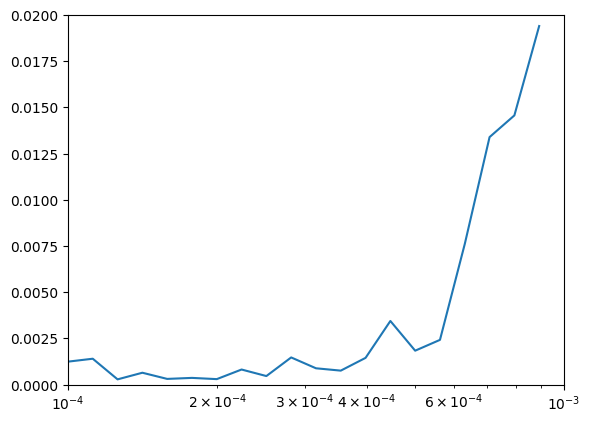

In [ ]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 1e-3, 0, 0.02])

## Train the Model

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=7.9433e-04), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
# Note that this may take some time.
history=model.fit(
    train_generator,
    steps_per_epoch=40, 
    epochs=15,
    validation_data=validation_generator, 
    validation_steps=15, 
    verbose=2,
    )

Epoch 1/15
40/40 - 8s - loss: 0.0332 - accuracy: 0.9945 - val_loss: 1.2245 - val_accuracy: 0.8792 - 8s/epoch - 204ms/step
Epoch 2/15
40/40 - 9s - loss: 0.0418 - accuracy: 0.9930 - val_loss: 0.9637 - val_accuracy: 0.8854 - 9s/epoch - 219ms/step
Epoch 3/15
40/40 - 10s - loss: 0.0067 - accuracy: 0.9977 - val_loss: 1.1108 - val_accuracy: 0.8708 - 10s/epoch - 261ms/step
Epoch 4/15
40/40 - 8s - loss: 0.0144 - accuracy: 0.9961 - val_loss: 0.9735 - val_accuracy: 0.8771 - 8s/epoch - 198ms/step
Epoch 5/15
40/40 - 9s - loss: 0.0223 - accuracy: 0.9953 - val_loss: 0.9043 - val_accuracy: 0.8875 - 9s/epoch - 216ms/step
Epoch 6/15
40/40 - 10s - loss: 0.0195 - accuracy: 0.9937 - val_loss: 1.6039 - val_accuracy: 0.8375 - 10s/epoch - 261ms/step
Epoch 7/15
40/40 - 8s - loss: 0.0154 - accuracy: 0.9937 - val_loss: 1.0412 - val_accuracy: 0.8792 - 8s/epoch - 199ms/step
Epoch 8/15
40/40 - 8s - loss: 0.0410 - accuracy: 0.9883 - val_loss: 0.8804 - val_accuracy: 0.8896 - 8s/epoch - 196ms/step
Epoch 9/15
40/40 - 8

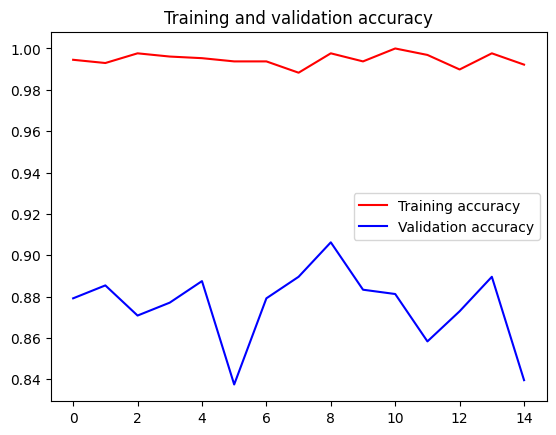

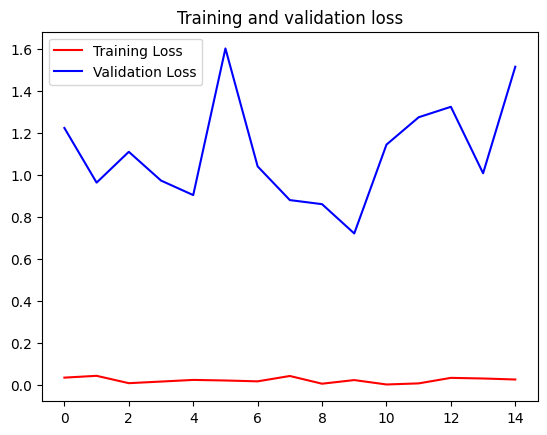

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()